# Cross Section for Many Lines using PreMODIT

Update: October 30/2022, Hajime Kawahara

We demonstarte the Precomputation of opacity version of Modified Discrete Integral Transform (PreMODIT), which is the modified version of MODIT for exojax. PreMODIT uses the evenly-spaced logarithm grid (ESLOG) as a wavenumber dimension. PreMODIT takes advantage especially for the case that the number of the molecular line is large (typically > 100,000). 

Here, we use FP64, but if you want you can use FP32 (but slightly large errors):

In [1]:
from jax.config import config
config.update("jax_enable_x64", True)

In [2]:
import matplotlib.pyplot as plt
from exojax.spec.hitran import line_strength, doppler_sigma, gamma_hitran, gamma_natural
from exojax.spec import api
from exojax.utils.grids import wavenumber_grid

# Setting wavenumber bins and loading HITRAN database
nu_grid, wav, R = wavenumber_grid(1900.0,
                              2300.0,
                              350000,
                              unit="cm-1",
                              xsmode="premodit")
isotope=1
mdbCO = api.MdbHitran('CO', nu_grid, isotope=isotope)

# set T, P and partition function
Mmol = 28.01  # molecular weight
Tfix = 1000.0  # we assume T=1000K
Pfix = 1.e-3  # we compute P=1.e-3 bar
Ppart = Pfix  #partial pressure of CO. here we assume a 100% CO atmosphere.


2023-03-15 08:31:41.511257: E external/org_tensorflow/tensorflow/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error


xsmode =  premodit
xsmode assumes ESLOG in wavenumber space: mode=premodit


We need to precompute some quantities. These can be computed using initspec.init_premodit. 
In PreMODIT, we need to specify (Twt and Tref). You might need to change dE to ensure the precision of the cross section.  

In [3]:
from exojax.spec import initspec

Twt = 1000.0
Tref = 400.0
dit_grid_resolution = 0.2
lbd, multi_index_uniqgrid, elower_grid, ngamma_ref_grid, n_Texp_grid, R, pmarray = initspec.init_premodit(
    mdbCO.nu_lines,
    nu_grid,
    mdbCO.elower,
    mdbCO.gamma_air,
    mdbCO.n_air,
    mdbCO.line_strength_ref,
    Twt=Twt,
    Tref=Tref,
    dit_grid_resolution=dit_grid_resolution,
    diffmode=0,
    warning=False)


uniqidx: 100%|██████████| 4/4 [00:00<00:00, 21236.98it/s]


Premodit: Twt= 1000.0 K Tref= 400.0 K
Making LSD:|####################| 100%


Precompute the normalized Dopper width and the partition function ratio:

In [4]:
from exojax.spec import normalized_doppler_sigma

molecular_mass = mdbCO.molmass
nsigmaD = normalized_doppler_sigma(Tfix, molecular_mass, R)
qt = mdbCO.qr_interp(isotope, Tfix)
    

Let's compute the cross section! The current PreMODIT has three different diffmode. We initialized PreMODIT with diffmode=0. Then, we should use xsvector_zeroth.

In [5]:
from exojax.spec.premodit import xsvector_zeroth

xs = xsvector_zeroth(Tfix, Pfix, nsigmaD, lbd, Tref, R, pmarray, nu_grid,
                   elower_grid, multi_index_uniqgrid, ngamma_ref_grid,
                   n_Texp_grid, qt)
    


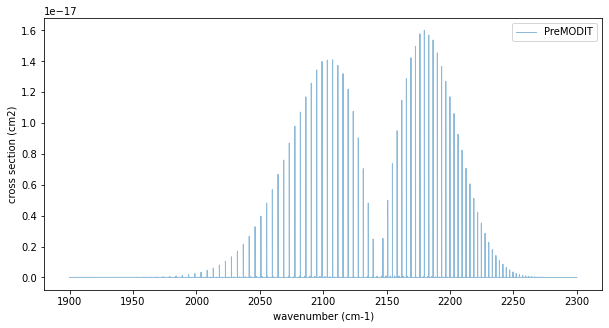

In [6]:
fig=plt.figure(figsize=(10,5))
ax=fig.add_subplot(111)
plt.plot(nu_grid,xs,lw=1,alpha=0.5,label="PreMODIT")
plt.legend(loc="upper right")
plt.xlabel("wavenumber (cm-1)")
plt.ylabel("cross section (cm2)")
plt.show()